In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import tensorflow as tf
print('GPU name: ', tf.config.experimental.list_physical_devices('GPU'))
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

GPU name:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 464032636792473217
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14357954560
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2467263353600319592
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [ ]:
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input, decode_predictions


In [ ]:
# Specifica i percorsi delle cartelle di addestramento e validazione
train_data_dir = '/content/drive/MyDrive/ORGANOIDS_EXPERIMENTS/Final_Organoids_Dataset/train_folder'
val_data_dir = '/content/drive/MyDrive/ORGANOIDS_EXPERIMENTS/Final_Organoids_Dataset/val_folder'

In [ ]:
from tensorflow.keras.layers import Input

# this could also be the output a different Keras model or layer
input_tensor = Input(shape=(224, 224, 3))

In [ ]:
#base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model = DenseNet169(weights='imagenet', include_top=False)

51877672/51877672 [==============================] - 0s 0us/step


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D


# Reference to the output of the base model
x = base_model.output

# Add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# Add a dense layer
x = Dense(512, activation='relu')(x)

# Add final dense layer for 4 classes with softmax activation
predictions = Dense(4, activation='softmax')(x)

# Construct the final model
model = Model(inputs=base_model.input, outputs=predictions)

# (Optional) To only train the top layers and freeze the rest:
for layer in base_model.layers:
    layer.trainable = False

# Compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, None, None, 3)        0         ['input_2[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, None, None, 64)       9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, None, None, 64)       256       ['conv1/conv[0][0]']      

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
batch_size = 128
num_epochs = 40

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Utilizza l'ImageDataGenerator per la generazione di dati
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Definisci i generatori di dati per l'addestramento e la validazione
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 18537 images belonging to 4 classes.
Found 2058 images belonging to 4 classes.


In [ ]:
import time
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Define the ModelCheckpoint callback
checkpoint_filepath = '/content/best_model.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

# Define the EarlyStopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=10,  # Number of epochs with no improvement after which training will be stopped
    verbose=1,
    restore_best_weights=True
)

# Start measuring time
start_time = time.time()

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=num_epochs,
    validation_data=val_generator,
    validation_steps=val_generator.n // batch_size,
    callbacks=[model_checkpoint_callback, early_stopping_callback]  # Add both callbacks to the list
)

# End measuring time
end_time = time.time()

# Calculate computational cost
computational_cost = end_time - start_time

# Print computational cost
print(f"Computational cost for model.fit: {computational_cost} seconds")


Epoch 1/40
144/144 [==============================] - ETA: 0s - loss: 0.5549 - accuracy: 0.7850 
Epoch 1: val_loss improved from inf to 0.42806, saving model to /content/best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


144/144 [==============================] - 3173s 21s/step - loss: 0.5549 - accuracy: 0.7850 - val_loss: 0.4281 - val_accuracy: 0.8208
Epoch 2/40
144/144 [==============================] - ETA: 0s - loss: 0.4027 - accuracy: 0.8389
Epoch 2: val_loss did not improve from 0.42806
144/144 [==============================] - 82s 566ms/step - loss: 0.4027 - accuracy: 0.8389 - val_loss: 0.4349 - val_accuracy: 0.8223
Epoch 3/40
144/144 [==============================] - ETA: 0s - loss: 0.3781 - accuracy: 0.8500
Epoch 3: val_loss improved from 0.42806 to 0.40361, saving model to /content/best_model.h5
144/144 [==============================] - 82s 569ms/step - loss: 0.3781 - accuracy: 0.8500 - val_loss: 0.4036 - val_accuracy: 0.8418
Epoch 4/40
144/144 [==============================] - ETA: 0s - loss: 0.3506 - accuracy: 0.8617
Epoch 4: val_loss improved from 0.40361 to 0.38208, saving model to /content/best_model.h5
144/144 [==============================] - 82s 566ms/step - loss: 0.3506 - accura

In [ ]:
#track the curve
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

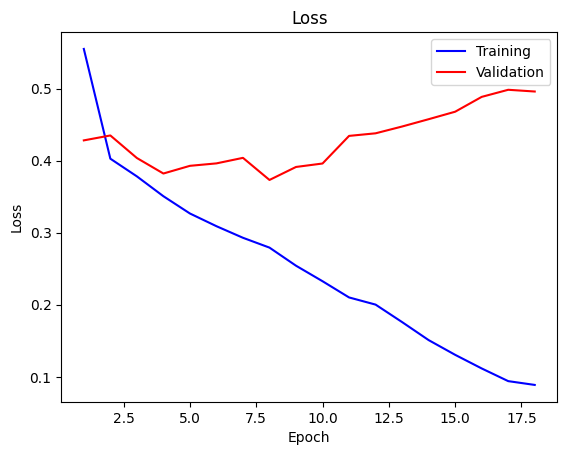

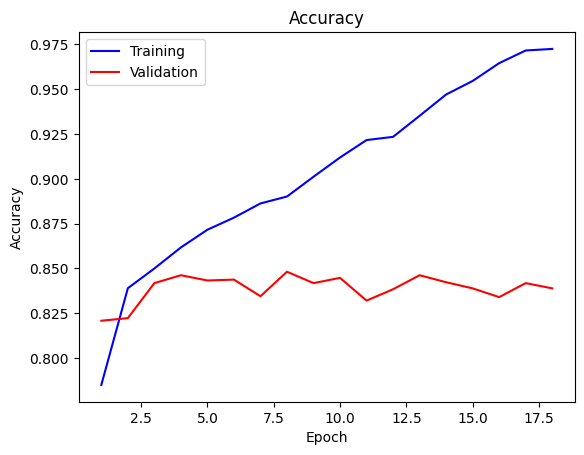

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have defined train_loss, val_loss, train_acc, and val_acc

epochs = range(1, len(train_loss) + 1)

# Plot and save the loss figure with 600 DPI
plt.plot(epochs, train_loss, 'b-', label='Training')
plt.plot(epochs, val_loss, 'r-', label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Save the figure in a suitable format (e.g., PNG) with 600 DPI for line drawings
plt.savefig('loss_plot_line_drawings.png', format='png', dpi=600, bbox_inches='tight')
plt.show()

# Plot and save the accuracy figure with 600 DPI
plt.plot(epochs, train_acc, 'b-', label='Training')
plt.plot(epochs, val_acc, 'r-', label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Save the figure in a suitable format (e.g., PNG) with 600 DPI for line drawings
plt.savefig('accuracy_plot_line_drawings.png', format='png', dpi=600, bbox_inches='tight')
plt.show()


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_data_dir = '/content/drive/MyDrive/ORGANOIDS_EXPERIMENTS/Final_Organoids_Dataset/test_folder'

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 2468 images belonging to 4 classes.


In [ ]:
#DA PROVARE

import time
import numpy as np
from keras.models import load_model

# Load the best model
model_path = '/content/best_model.h5'
model = load_model(model_path)

# Start measuring time
start_time = time.time()

# Assuming you have defined test_generator
# This is just for measuring the time spent on loading data and making predictions

# Load true labels
y_true = test_generator.classes  # Etichette reali

# Make predictions
y_pred = model.predict(test_generator)  # Previsioni del modello

# Calculate predicted classes
y_pred_classes = np.argmax(y_pred, axis=1)  # Classi predette

# End measuring time
end_time = time.time()

# Calculate computational cost
computational_cost = end_time - start_time

# Print computational cost
print(f"Computational cost: {computational_cost} seconds")

20/20 [==============================] - 335s 17s/step
Computational cost: 345.9996876716614 seconds


In [ ]:
y_pred

array([[9.9890649e-01, 1.0506544e-03, 2.4233825e-07, 4.2593467e-05],
       [9.9721140e-01, 3.9394721e-04, 9.7265900e-07, 2.3936634e-03],
       [9.8215699e-01, 2.0893957e-03, 9.6710232e-07, 1.5752517e-02],
       ...,
       [9.3144906e-01, 6.4946570e-02, 1.1411470e-04, 3.4902215e-03],
       [9.9790490e-01, 2.8655838e-04, 2.6130368e-07, 1.8083013e-03],
       [6.5351737e-01, 2.0227180e-04, 2.0993750e-05, 3.4625942e-01]],
      dtype=float32)

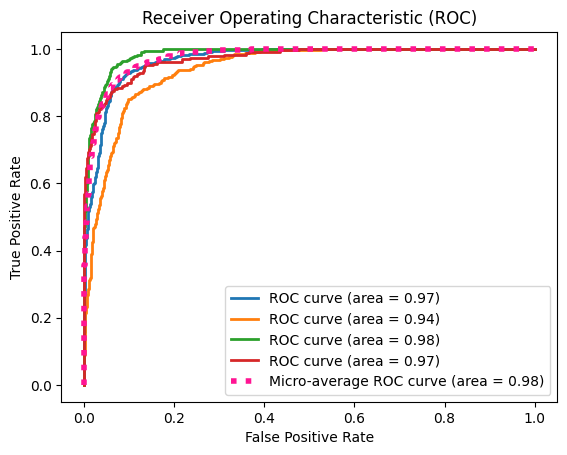

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Assuming you have defined y_true and y_pred_classes as described in your code
# y_true contains true labels, and y_pred_classes contains predicted classes

# Binarize the true labels (one-hot encoding)
n_classes = len(np.unique(y_true))
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves for each class
plt.figure()
lw = 2
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[i])

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label='Micro-average ROC curve (area = %0.2f)' % roc_auc["micro"],
         color='deeppink', linestyle=':', linewidth=4)

# Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
# Save the figure in a suitable format (e.g., PNG) with 600 DPI for line drawings
plt.savefig('roc_curves.png', format='png', dpi=600, bbox_inches='tight')
plt.show()


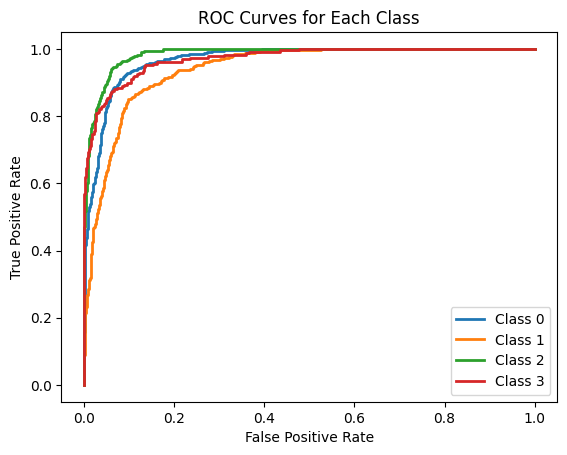

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Assuming you have defined y_true and y_pred as described in your previous code
# y_true contains true labels, and y_pred contains predicted probabilities

# Binarize the true labels (one-hot encoding)
n_classes = 4  # Number of classes (change to your actual number of classes)
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

# Initialize dictionaries to store FPR and TPR for each class
fpr_dict = {}
tpr_dict = {}

# Compute ROC curve and ROC area for each class
for i in range(n_classes):
    fpr_dict[i], tpr_dict[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])

# Plot ROC curves for each class
plt.figure()
lw = 2
for i in range(n_classes):
    plt.plot(fpr_dict[i], tpr_dict[i], lw=lw, label=f'Class {i}')

# Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend(loc="lower right")
plt.savefig('roc_curves_for_class.png', format='png', dpi=600, bbox_inches='tight')

# Show the plot
plt.show()

# Save FPR and TPR values to separate CSV files for each class
for i in range(n_classes):
    class_name = f'Class_{i}'
    fpr = fpr_dict[i]
    tpr = tpr_dict[i]

    # Save FPR and TPR values for the class to a CSV file
    with open(f'{class_name}_roc_curve.csv', 'w') as file:
        file.write('False Positive Rate, True Positive Rate\n')
        for j in range(len(fpr)):
            file.write(f'{fpr[j]}, {tpr[j]}\n')


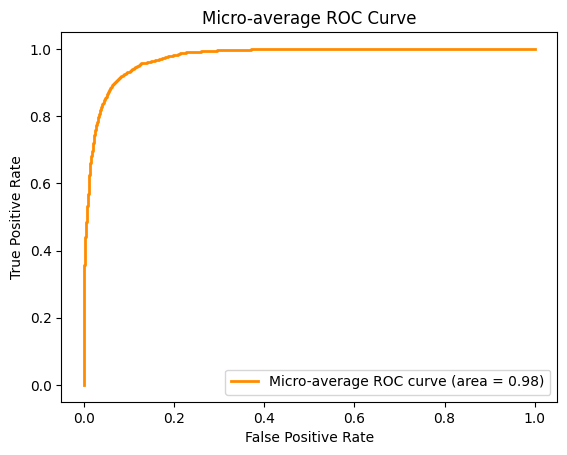

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Assuming you have defined y_true and y_pred as described in your previous code
# y_true contains true labels, and y_pred contains predicted probabilities

# Binarize the true labels (one-hot encoding)
n_classes = 4  # Number of classes (change to your actual number of classes)
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(y_true_bin.ravel(), y_pred.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plot the micro-average ROC curve
plt.figure()
lw = 2
plt.plot(fpr_micro, tpr_micro, color='darkorange',
         lw=lw, label=f'Micro-average ROC curve (area = {roc_auc_micro:.2f})')

# Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average ROC Curve')
plt.legend(loc="lower right")
plt.savefig('micro_avg_roc_curves.png', format='png', dpi=600, bbox_inches='tight')


# Show the plot
plt.show()

import pandas as pd

# Create a dataframe with fpr_micro and tpr_micro
df = pd.DataFrame({'fpr_micro': fpr_micro, 'tpr_micro': tpr_micro})

# Save the dataframe to a CSV file
df.to_csv('fpr_tpr_micro_values.csv', index=False)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Accuracy: 0.8545380875202593
Precision: 0.8552938369114326
Recall: 0.8545380875202593
F1-score: 0.8535491943368578


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='macro')
recall = recall_score(y_true, y_pred_classes, average='macro')
f1 = f1_score(y_true, y_pred_classes, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.8545380875202593
Precision: 0.8409844515670463
Recall: 0.7993223257876848
F1-score: 0.817477141369789


In [ ]:
confusion_mtx = confusion_matrix(y_true, y_pred_classes)
print("Matrice di confusione:")
print(confusion_mtx)

Matrice di confusione:
[[1214   58    0   22]
 [  75  423   46    4]
 [   1   87  313    0]
 [  56    9    1  159]]


In [ ]:
# Assuming you have defined confusion_mtx as described in your code

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_mtx)

# Save the confusion matrix values to a text file (e.g., CSV)
with open('confusion_matrix.csv', 'w') as file:
    file.write("Confusion Matrix:\n")
    for row in confusion_mtx:
        file.write(','.join(map(str, row)) + '\n')

Confusion Matrix:
[[1214   58    0   22]
 [  75  423   46    4]
 [   1   87  313    0]
 [  56    9    1  159]]


In [ ]:
#print PPT

import numpy as np
from sklearn.metrics import roc_curve

# Assuming you have defined y_true and y_pred as described in your previous code
# y_true contains true labels, and y_pred contains predicted probabilities

# Binarize the true labels (one-hot encoding)
n_classes = 4  # Number of classes (change to your actual number of classes)
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

# Initialize dictionaries to store FPR and TPR for each class
fpr_dict = {}
tpr_dict = {}

# Compute ROC curve for each class
for i in range(n_classes):
    fpr_dict[i], tpr_dict[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])

# Print TPR and FPR for each class
for i in range(n_classes):
    print(f"Class {i}:")
    print(f"TPR (True Positive Rate): {tpr_dict[i]}")
    print(f"FPR (False Positive Rate): {fpr_dict[i]}")
    print()


Class 0:
TPR (True Positive Rate): [0.00000000e+00 7.72797527e-04 9.50540958e-02 9.50540958e-02
 1.58423493e-01 1.58423493e-01 2.41112828e-01 2.41112828e-01
 3.48531685e-01 3.48531685e-01 4.14992272e-01 4.14992272e-01
 4.26584235e-01 4.26584235e-01 4.36630603e-01 4.36630603e-01
 4.48222566e-01 4.48222566e-01 4.52859351e-01 4.52859351e-01
 4.65224111e-01 4.65224111e-01 5.07727975e-01 5.07727975e-01
 5.16228748e-01 5.16228748e-01 5.29366306e-01 5.29366306e-01
 5.30911901e-01 5.30911901e-01 5.32457496e-01 5.32457496e-01
 5.37094281e-01 5.37094281e-01 5.46367852e-01 5.46367852e-01
 5.57959815e-01 5.57959815e-01 5.64914992e-01 5.64914992e-01
 5.74961360e-01 5.74961360e-01 5.76506955e-01 5.76506955e-01
 5.91962906e-01 5.91962906e-01 5.97372488e-01 5.97372488e-01
 5.98145286e-01 5.98145286e-01 6.01236476e-01 6.01236476e-01
 6.03554869e-01 6.03554869e-01 6.15919629e-01 6.15919629e-01
 6.19783617e-01 6.19783617e-01 6.22102009e-01 6.22102009e-01
 6.29057187e-01 6.29057187e-01 6.32921175e-01 6.32

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Assuming you have defined y_true and y_pred_classes as described in your previous code
# y_true contains true labels, and y_pred_classes contains predicted classes

# Calculate confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Calculate classification report
classification_rep = classification_report(y_true, y_pred_classes)

# Calculate overall accuracy
accuracy = np.mean(y_true == y_pred_classes)

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_mtx)

# Print classification report
print("\nClassification Report:")
print(classification_rep)

# Print overall accuracy
print(f"\nOverall Accuracy: {accuracy:.2%}")


Confusion Matrix:
[[1214   58    0   22]
 [  75  423   46    4]
 [   1   87  313    0]
 [  56    9    1  159]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      1294
           1       0.73      0.77      0.75       548
           2       0.87      0.78      0.82       401
           3       0.86      0.71      0.78       225

    accuracy                           0.85      2468
   macro avg       0.84      0.80      0.82      2468
weighted avg       0.86      0.85      0.85      2468


Overall Accuracy: 85.45%


In [ ]:
from sklearn.metrics import confusion_matrix

# Assuming you have defined y_true and y_pred_classes as described in your previous code
# y_true contains true labels, and y_pred_classes contains predicted classes

# Calculate the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Calculate sensitivity (TPR) and specificity for each class
sensitivity = []
specificity = []

for i in range(len(confusion_mtx)):
    true_positives = confusion_mtx[i, i]
    false_negatives = np.sum(confusion_mtx[i, :]) - true_positives
    true_negatives = np.sum(confusion_mtx) - np.sum(confusion_mtx[i, :]) - np.sum(confusion_mtx[:, i]) + true_positives
    false_positives = np.sum(confusion_mtx[:, i]) - true_positives

    sensitivity_i = true_positives / (true_positives + false_negatives)
    specificity_i = true_negatives / (true_negatives + false_positives)

    sensitivity.append(sensitivity_i)
    specificity.append(specificity_i)

# Print sensitivity and specificity for each class
for i in range(len(sensitivity)):
    print(f"Class {i}:")
    print(f"Sensitivity (True Positive Rate): {sensitivity[i]:.2f}")
    print(f"Specificity (True Negative Rate): {specificity[i]:.2f}")
    print()


Class 0:
Sensitivity (True Positive Rate): 0.94
Specificity (True Negative Rate): 0.89

Class 1:
Sensitivity (True Positive Rate): 0.77
Specificity (True Negative Rate): 0.92

Class 2:
Sensitivity (True Positive Rate): 0.78
Specificity (True Negative Rate): 0.98

Class 3:
Sensitivity (True Positive Rate): 0.71
Specificity (True Negative Rate): 0.99



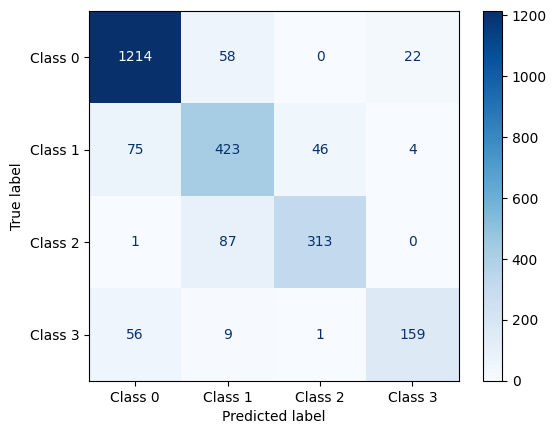

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay


# Display labels for the classes
display_labels = ['Class 0', 'Class 1', 'Class 2', 'Class 3']

# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mtx, display_labels=display_labels)

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues)

# Save the figure as a PNG file
plt.savefig('cm_conf_4_classes.png', dpi=100)

# Show the plot
plt.show()


In [ ]:
confusion_mtx

array([[1214,   58,    0,   22],
       [  75,  423,   46,    4],
       [   1,   87,  313,    0],
       [  56,    9,    1,  159]])

In [ ]:
import numpy as np

def print_confusion_matrix(matrix):
    print("Confusion Matrix:")
    print("array(", end='')
    for i, row in enumerate(matrix):
        if i == 0:
            print("[", end='')
        else:
            print("       [", end='')

        for j, value in enumerate(row):
            end_char = ", " if j < len(row) - 1 else "]"
            print(f"{value:>4}", end=end_char)

        if i < len(matrix) - 1:
            print(",")
        else:
            print("])")

# Test
matrix =confusion_mtx
print_confusion_matrix(matrix)


Confusion Matrix:
array([1214,   58,    0,   22],
       [  75,  423,   46,    4],
       [   1,   87,  313,    0],
       [  56,    9,    1,  159]])


In [ ]:
import numpy as np

def compute_metrics(matrix):
    num_classes = matrix.shape[0]

    # True positives
    TP = np.diag(matrix)

    # False positives
    FP = matrix.sum(axis=0) - TP

    # False negatives
    FN = matrix.sum(axis=1) - TP

    # True negatives
    TN = matrix.sum() - (FP + FN + TP)

    # Accuracy
    overall_accuracy = TP.sum() / matrix.sum()

    # Sensitivity/Recall
    sensitivity = TP / (TP + FN)

    # Specificity
    specificity = TN / (TN + FP)

    # Precision
    precision = TP / (TP + FP)

    # F1 Score
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity)

    return overall_accuracy, sensitivity, specificity, f1_score

# Test
matrix = confusion_mtx
overall_accuracy, sensitivity, specificity, f1_score = compute_metrics(matrix)

print(f"Overall Accuracy: {overall_accuracy:.4f}")
for i in range(matrix.shape[0]):
    print(f"\nClass {i} metrics:")
    print(f"Sensitivity/Recall: {sensitivity[i]:.4f}")
    print(f"Specificity: {specificity[i]:.4f}")
    print(f"F1 Score: {f1_score[i]:.4f}")


Overall Accuracy: 0.8545

Class 0 metrics:
Sensitivity/Recall: 0.9382
Specificity: 0.8876
F1 Score: 0.9197

Class 1 metrics:
Sensitivity/Recall: 0.7719
Specificity: 0.9198
F1 Score: 0.7520

Class 2 metrics:
Sensitivity/Recall: 0.7805
Specificity: 0.9773
F1 Score: 0.8226

Class 3 metrics:
Sensitivity/Recall: 0.7067
Specificity: 0.9884
F1 Score: 0.7756


In [ ]:
import numpy as np

def compute_metrics(matrix):
    num_classes = matrix.shape[0]

    # True positives
    TP = np.diag(matrix)

    # False positives
    FP = matrix.sum(axis=0) - TP

    # False negatives
    FN = matrix.sum(axis=1) - TP

    # True negatives
    TN = matrix.sum() - (FP + FN + TP)

    # Accuracy
    overall_accuracy = TP.sum() / matrix.sum()

    # Micro-average Sensitivity/Recall
    micro_recall = TP.sum() / (TP.sum() + FN.sum())

    # Micro-average Precision
    micro_precision = TP.sum() / (TP.sum() + FP.sum())

    # Micro-average F1 Score
    micro_f1_score = 2 * (micro_precision * micro_recall) / (micro_precision + micro_recall)

    # Micro-average Specificity
    micro_specificity = TN.sum() / (TN.sum() + FP.sum())

    return overall_accuracy, micro_recall, micro_specificity, micro_f1_score

# Test
matrix = confusion_mtx

overall_accuracy, micro_recall, micro_specificity, micro_f1_score = compute_metrics(matrix)

print(f"Overall Accuracy: {overall_accuracy:.4f}")
print(f"Micro-average Sensitivity/Recall: {micro_recall:.4f}")
print(f"Micro-average Specificity: {micro_specificity:.4f}")
print(f"Micro-average F1 Score: {micro_f1_score:.4f}")


Overall Accuracy: 0.8545
Micro-average Sensitivity/Recall: 0.8545
Micro-average Specificity: 0.9515
Micro-average F1 Score: 0.8545
